In [1]:
import pandas as pd
import seaborn as sns
from datetime import date

/var/folders/9n/b1lb14dd11v9kphcqy_pd2_h0000gn/T/ipykernel_76680/3816144820.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
apps=pd.read_csv("googleplaystore.csv")
apps=apps.drop_duplicates(subset="App")
print(len(apps))
print(apps.dtypes)

9660
Unnamed: 0          int64
App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object


In [3]:
# Removes the first columns(Unnamed: 0) which contains extra indexing (Cleaning 1.1)

apps.drop(columns=apps.columns[0], axis=1, inplace=True)
print(apps.dtypes)

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object


In [4]:
# Rating Column

apps["Rating"].value_counts()

Rating
4.3     897
4.4     895
4.5     848
4.2     810
4.6     683
4.1     621
4.0     513
4.7     442
3.9     359
3.8     286
5.0     271
3.7     224
4.8     221
3.6     167
3.5     156
3.4     126
3.3     100
4.9      85
3.0      81
3.1      69
3.2      63
2.9      45
2.8      40
2.6      24
2.7      23
2.5      20
2.3      20
2.4      19
1.0      16
2.2      14
2.0      12
1.9      11
1.7       8
1.8       8
2.1       8
1.6       4
1.4       3
1.5       3
1.2       1
19.0      1
Name: count, dtype: int64

In [5]:
# Cleaning Rating column (Cleaning 2 and 3)

# Replace apps with no rating to 0
apps["Rating"]= apps["Rating"].fillna(0)
# Remove any invalid rating
apps = apps.drop(apps[apps["Rating"] > 5].index)
print(apps["Rating"].value_counts)

<bound method IndexOpsMixin.value_counts of 0        4.1
1        3.9
2        4.7
3        4.5
4        4.3
        ... 
10836    4.5
10837    5.0
10838    0.0
10839    4.5
10840    4.5
Name: Rating, Length: 9659, dtype: float64>


In [6]:
# Cleaning Size column (Cleaning 4)

# Function used to conver file size from KB to MB
def KBtoMB(size):
    if size == "Varies with device":
        return size
    unit = size[-1]
    size = float(size[:-1])
    if unit == 'k':
        size = size/1000
    return size

# Conver all entries with a size to MB as float
apps["Size"] = apps["Size"].apply(KBtoMB)

# All size values are unified in terms of MB in int64/float, but "Varies with device" still exit.
print(apps["Size"].value_counts())




Size
Varies with device    1227
11.0                   182
12.0                   181
13.0                   177
14.0                   177
                      ... 
0.43                     1
0.429                    1
0.2                      1
0.46                     1
0.619                    1
Name: count, Length: 460, dtype: int64


In [7]:
# Replace app size with "Varies with device" with the size mean of its catagory (Cleaning 5)

# Exclude app with "Varies with device" when calculating the mean
apps_with_size = apps[apps["Size"] != "Varies with device"]

# List containes all categorys of apps
categorys = list(set(apps["Category"].values))

# Dictionary maps the category and its size mean
size_mean = {}

# Calculting the mean
for category in categorys:
    cat_mean = apps_with_size[apps_with_size["Category"] == category]
    size_mean[category] = float(cat_mean["Size"].mean())

# Updating the data frame by replacing "Varies with device" with corresponding catgory mean
for ind in apps.index:
    category = apps['Category'][ind]
    size = apps['Size'][ind]
    if size == "Varies with device":
        apps.at[ind, "Size"] = size_mean[category]

# No more "Varies with device"
apps["Size"].value_counts

<bound method IndexOpsMixin.value_counts of 0             19.0
1             14.0
2              8.7
3             25.0
4              2.8
           ...    
10836         53.0
10837          3.6
10838          9.5
10839    13.134701
10840         19.0
Name: Size, Length: 9659, dtype: object>

In [8]:
# Content Rating column

apps["Content Rating"].value_counts()

Content Rating
Everyone           7903
Teen               1036
Mature 17+          393
Everyone 10+        322
Adults only 18+       3
Unrated               2
Name: count, dtype: int64

In [9]:
# Cleaning Content Rating column (Cleaning 6)

content_rating_replacements = {
    "Everyone": 0,
    "Teen": 13,
    "Everyone 10+": 10,
    "Mature 17+": 17,
    "Unrated": 0,
    "Adults only 18+": 18
}

# Replace the content ratings based on the mapping
apps['Content Rating'] = apps['Content Rating'].replace(content_rating_replacements)

# Explicitly convert the 'Content Rating' column to integer to avoid future warnings
apps['Content Rating'] = apps['Content Rating'].astype(int)

# Verify the changes
print(apps['Content Rating'].value_counts())

Content Rating
0     7905
13    1036
17     393
10     322
18       3
Name: count, dtype: int64


/var/folders/9n/b1lb14dd11v9kphcqy_pd2_h0000gn/T/ipykernel_76680/2675725504.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  apps['Content Rating'] = apps['Content Rating'].replace(content_rating_replacements)


In [10]:
# Price column

apps["Price"].value_counts()

Price
0           8903
$0.99        145
$2.99        124
$1.99         73
$4.99         70
            ... 
$18.99         1
$389.99        1
$19.90         1
$1.75          1
$1.04          1
Name: count, Length: 92, dtype: int64

In [11]:
# Cleaning Price column (Cleaning 7)

# Remove '$' from the price and conver to float
apps["Price"] = apps["Price"].apply(lambda x: float(x.strip('$')))
apps["Price"].value_counts()

Price
0.00      8903
0.99       145
2.99       124
1.99        73
4.99        70
          ... 
18.99        1
389.99       1
19.90        1
1.75         1
1.04         1
Name: count, Length: 92, dtype: int64

In [12]:
# Installs column

apps["Installs"].value_counts()

Installs
1,000,000+        1417
100,000+          1112
10,000+           1031
10,000,000+        937
1,000+             888
100+               710
5,000,000+         607
500,000+           505
50,000+            469
5,000+             468
10+                385
500+               328
50+                204
50,000,000+        202
100,000,000+       188
5+                  82
1+                  67
500,000,000+        24
1,000,000,000+      20
0+                  14
0                    1
Name: count, dtype: int64

In [13]:
# Cleaning Installs column (Cleaning 8)

# Function to remove non-numerical char from str and conver str to float
def converToFloat(number):
    number = number.strip('+').replace(',', '')
    return float(number)

# Apply to all values in Installs
apps["Installs"] = apps["Installs"].apply(lambda x: converToFloat(x))

apps["Installs"]

0           10000.0
1          500000.0
2         5000000.0
3        50000000.0
4          100000.0
            ...    
10836        5000.0
10837         100.0
10838        1000.0
10839        1000.0
10840    10000000.0
Name: Installs, Length: 9659, dtype: float64

In [14]:
# Cleaning Installs column(Cleaning 9)

# Function used to scale down number of installs by 1000
def convertInstalls(v):
    v = int(v)
    if v < 1000:    # Return 0 if number of installs is less than 1000, and 0 is used to represent less than 1000
        return 0
    v = v/1000
    return v

# Apply scaling to all entries in Installs
apps["Installs"] = apps["Installs"].apply(lambda x: convertInstalls(x))

apps["Installs"].value_counts()

Installs
0.0          1791
1000.0       1417
100.0        1112
10.0         1031
10000.0       937
1.0           888
5000.0        607
500.0         505
50.0          469
5.0           468
50000.0       202
100000.0      188
500000.0       24
1000000.0      20
Name: count, dtype: int64

In [15]:
# Last Updateed column

apps["Last Updated"].value_counts()

Last Updated
3-Aug-18     252
2-Aug-18     230
1-Aug-18     209
31-Jul-18    204
30-Jul-18    160
            ... 
8-Mar-15       1
25-Mar-15      1
9-Jul-14       1
11-Oct-14      1
23-Mar-14      1
Name: count, Length: 1377, dtype: int64

In [16]:
# Cleaning Last Updated column (Cleaning 10)

# Today's date
today = date.today()

# Take input date as str and return number of days since last update to today
def daysSinceUpdate(d):
    month_table = {
        "Jan": 1,
        "Feb": 2,
        "Mar": 3,
        "Apr": 4,
        "May": 5,
        "Jun": 6,
        "Jul": 7,
        "Aug": 8,
        "Sep": 9,
        "Oct": 10,
        "Nov": 11,
        "Dec": 12
    }
    d = d.split('-')
    Date = int(d[0])
    Month = month_table[d[1]]
    Year = int('20'+d[2])

    return (today - date(Year, Month, Date)).days

# Apply calculation to all entries
apps["Last Updated"] = apps["Last Updated"].apply(lambda x: daysSinceUpdate(x))

apps["Last Updated"].value_counts()

Last Updated
2033    252
2034    230
2035    209
2036    204
2037    160
       ... 
3277      1
3260      1
3519      1
3425      1
3627      1
Name: count, Length: 1377, dtype: int64

In [17]:
# Current Ver column have too many mission data(Varies with device)
apps["Current Ver"].value_counts()

Current Ver
Varies with device    1055
1                      831
1.1                    272
1.2                    183
2                      163
                      ... 
20180517                 1
3.1.00                   1
2.1.54                   1
32.1                     1
2.0.148.0                1
Name: count, Length: 2769, dtype: int64

In [18]:
# Adroid Ver column also have too many mission data(Varies with device)
apps["Android Ver"].value_counts()

Android Ver
4.1 and up            2202
4.0.3 and up          1395
4.0 and up            1285
Varies with device     990
4.4 and up             818
2.3 and up             616
5.0 and up             512
4.2 and up             372
2.3.3 and up           273
2.2 and up             239
3.0 and up             231
4.3 and up             221
2.1 and up             133
1.6 and up             116
6.0 and up              54
7.0 and up              42
3.2 and up              36
2.0 and up              32
5.1 and up              22
1.5 and up              20
4.4W and up             11
3.1 and up              10
2.0.1 and up             7
8.0 and up               6
7.1 and up               3
4.0.3 - 7.1.1            2
5.0 - 8.0                2
1.0 and up               2
7.0 - 7.1.1              1
4.1 - 7.1.1              1
5.0 - 6.0                1
2.2 - 7.1.1              1
5.0 - 7.1.1              1
Name: count, dtype: int64

In [19]:
# Remove both Current Ver and Adroid Ver column (Cleaning 1.2)

apps = apps.drop(columns=["Current Ver", "Android Ver"])
apps.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs          float64
Type               object
Price             float64
Content Rating      int64
Genres             object
Last Updated        int64
dtype: object

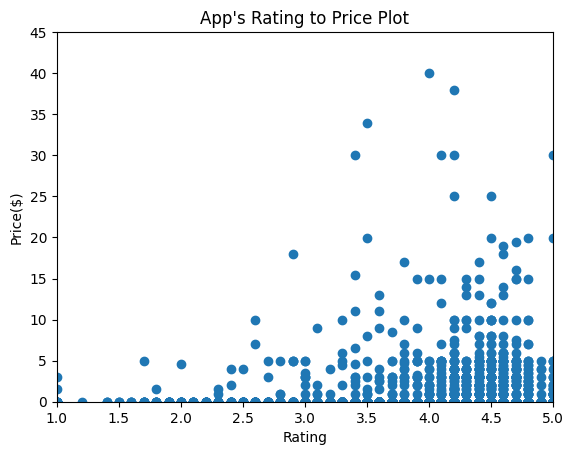

3.541142975463299
1.0992990992856404


In [20]:
from matplotlib import pyplot as plt

# Rating to price scatter plot (EDA 1)
rating = apps["Rating"]
price = apps["Price"]

plt.scatter(rating,price)
plt.title("App's Rating to Price Plot")
plt.xlabel("Rating")
plt.ylabel("Price($)")
plt.xlim(1,5)
plt.ylim(0,45)
plt.show()

print(rating.mean())
print(price.mean())

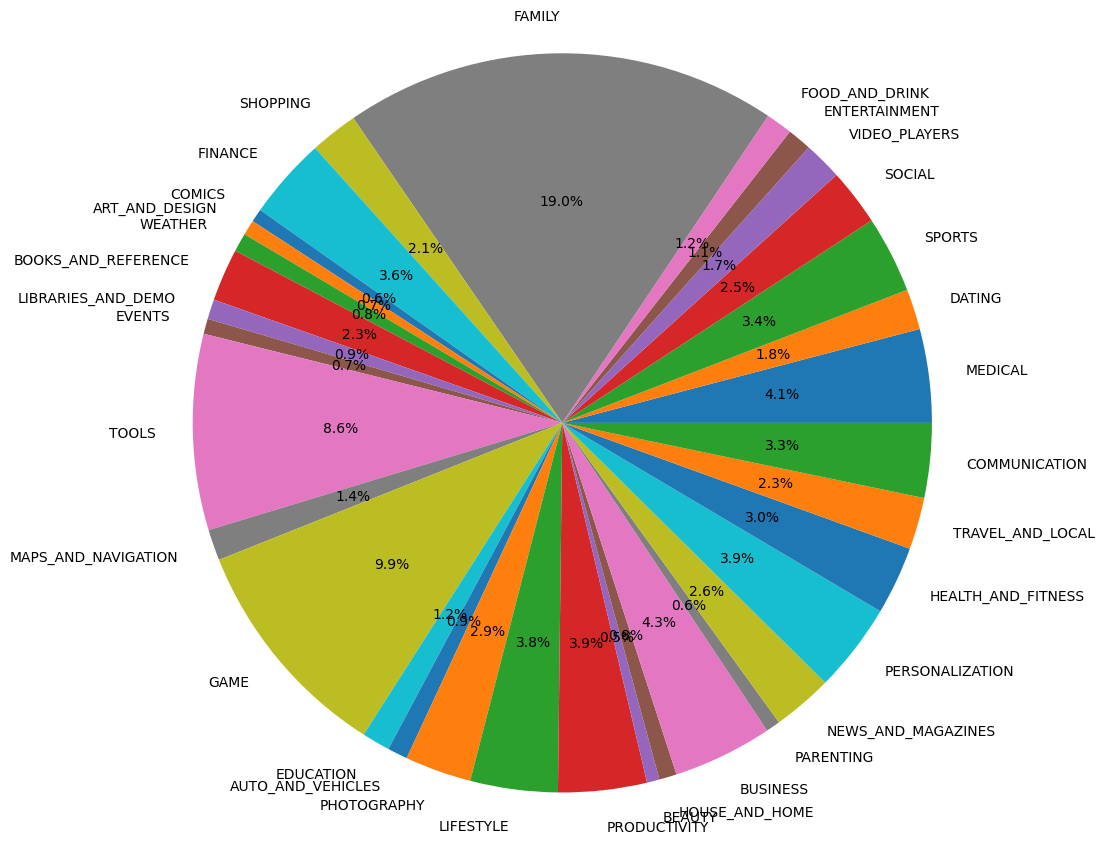

In [21]:
# Pie chart of distribution of apps based on its category (EDA 2)

count = []
for cat in categorys:
    count.append(len(apps[apps["Category"] == cat]))

plt.pie(count, labels=categorys, radius=2.5, autopct = '%1.1f%%')
plt.show()

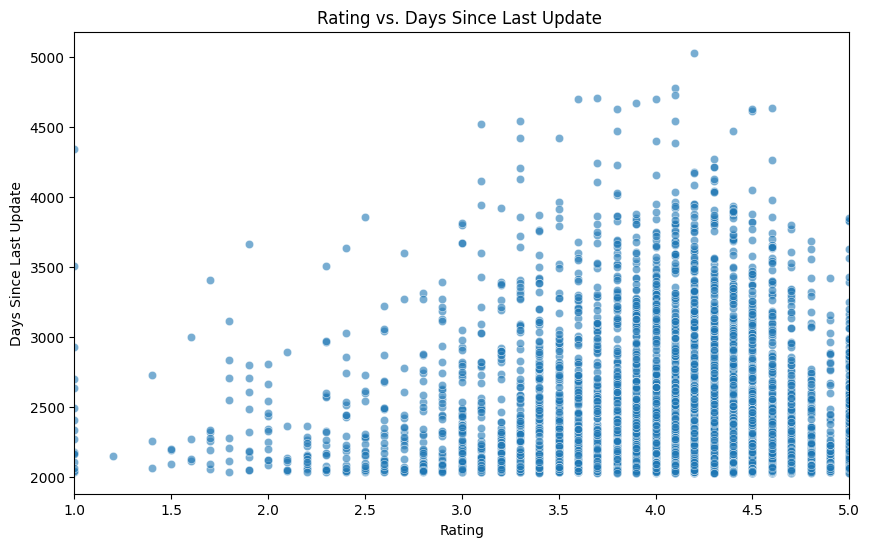

2309.184698208924
3.541142975463299


In [22]:
# Scatterplot of App's Rating to Days Since Last Update (EDA 3)

plt.figure(figsize=(10, 6))
A = apps["Last Updated"]
B = apps["Rating"]
sns.scatterplot(x=B, y=A, alpha=0.6)
plt.title('Rating vs. Days Since Last Update ')
plt.ylabel('Days Since Last Update')
plt.xlabel('Rating')
plt.xlim(1,5)
plt.show()

print(A.mean())
print(B.mean())

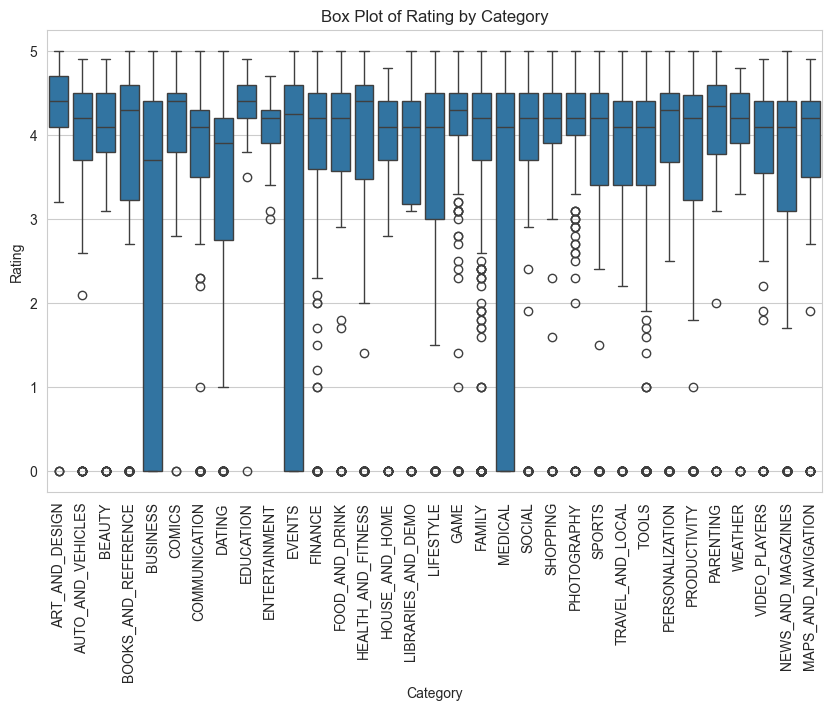

In [23]:
# Box Plot of Rating by Category (EDA 4)

sns.set_style('whitegrid')

plt.figure(figsize=(10, 6))


sns.boxplot(x=apps["Category"], y=apps["Rating"], data=apps)
plt.xticks(rotation=90)
plt.title('Box Plot of Rating by Category')
plt.xlabel('Category')
plt.ylabel('Rating')

plt.show()

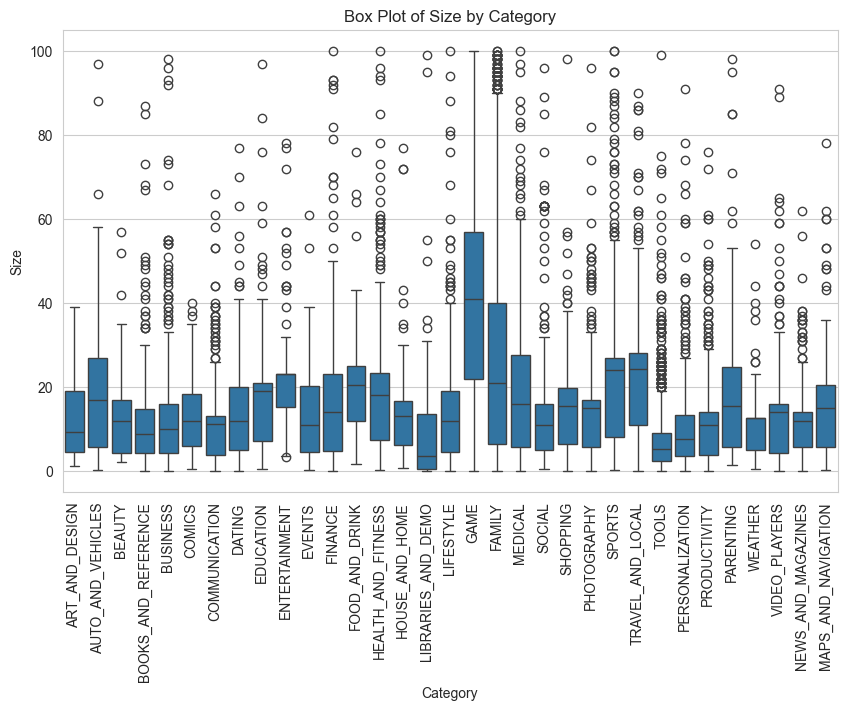

In [24]:
# Box plot of size by category (EDA 5)

sns.set_style('whitegrid')

plt.figure(figsize=(10, 6))


sns.boxplot(x=apps["Category"], y=apps["Size"], data=apps)
plt.xticks(rotation=90)
plt.title('Box Plot of Size by Category')
plt.xlabel('Category')
plt.ylabel('Size')

plt.show()

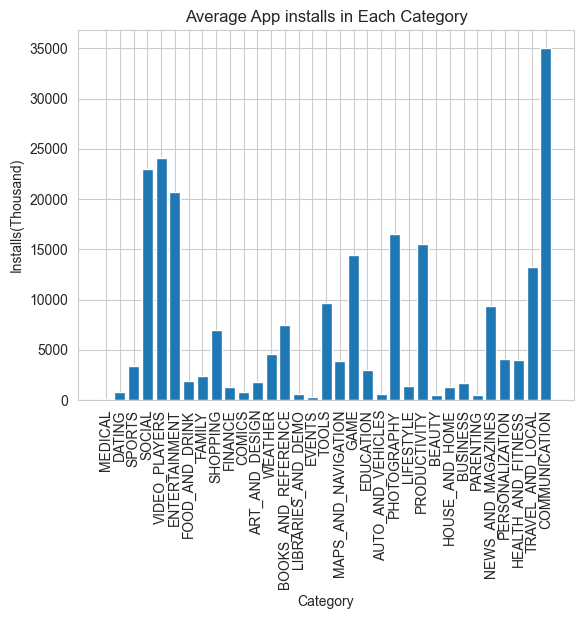

In [25]:
# Bar graph of average app installs of each category (EDA 6)

size = []

for cat in categorys:
    size.append(apps[apps["Category"] == cat]["Installs"].mean())

plt.bar(categorys, size)
plt.xticks(rotation=90)
plt.xlabel("Category")
plt.ylabel("Installs(Thousand)")
plt.title("Average App installs in Each Category")
plt.show()

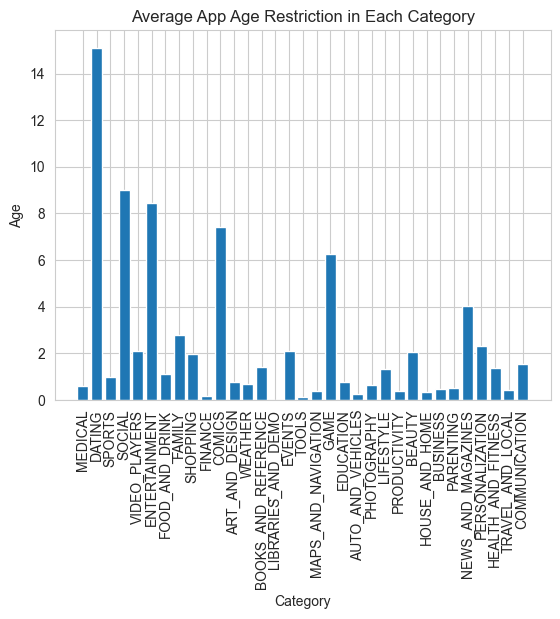

In [26]:
# Bar graph of average app age restriction of each category (EDA 7)

size = []

for cat in categorys:
    size.append(apps[apps["Category"] == cat]["Content Rating"].mean())

plt.bar(categorys, size)
plt.xticks(rotation=90)
plt.xlabel("Category")
plt.ylabel("Age")
plt.title("Average App Age Restriction in Each Category")
plt.show()

[0, 10, 13, 17, 18]


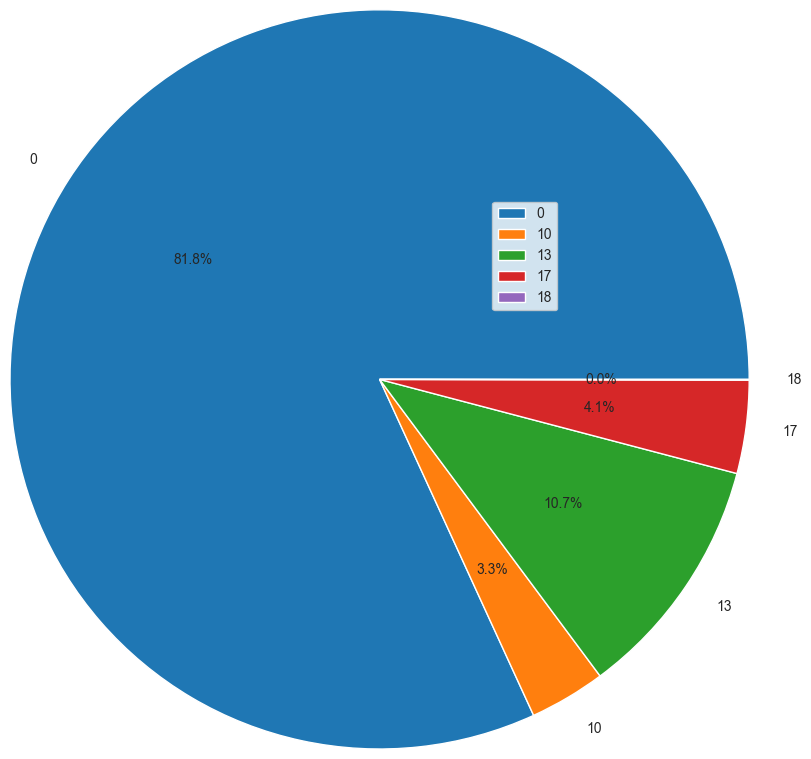

In [27]:
# Pie chart of content rating distibution (EDA 8)

count = []
con_rating = list(set(apps["Content Rating"].values))
print(con_rating)
for cat in con_rating:
    count.append(len(apps[apps["Content Rating"] == cat]))

plt.pie(count, labels=con_rating, radius=2.5, autopct = '%1.1f%%')
plt.legend()
plt.show()

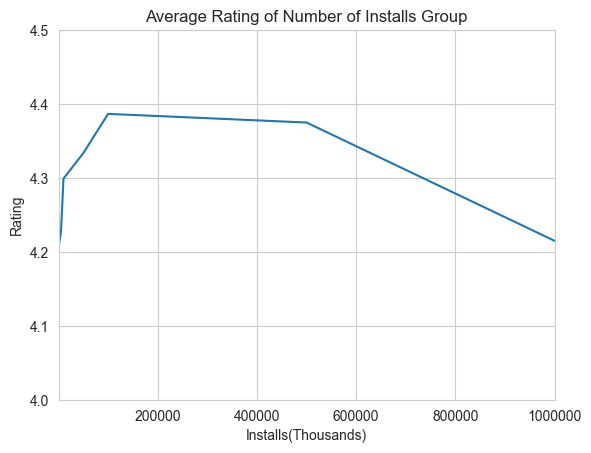

In [28]:
# Line graph of average rating of each number of install group (EDA 9)

install = apps["Installs"].value_counts().index
install = install.sort_values()
rating = []

for i in install:
    rating.append(apps[apps["Installs"] == i]["Rating"].mean())

plt.plot(install, rating)
plt.xlim(1,1000000)
plt.ylim(4, 4.5)

plt.xlabel("Installs(Thousands)")
plt.ylabel("Rating")
plt.title("Average Rating of Number of Installs Group")
plt.ticklabel_format(style='plain')
plt.show()

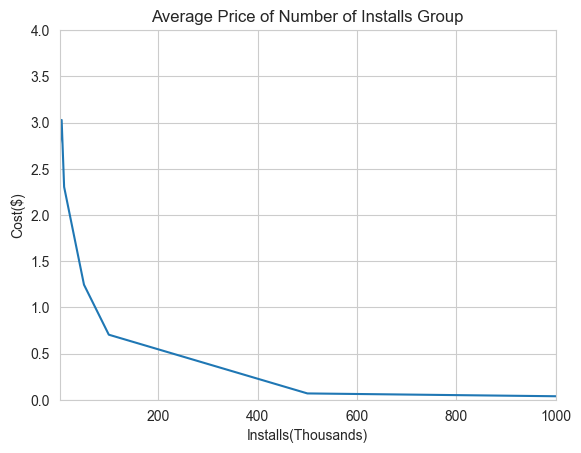

In [29]:
# Line graph of average price of each number of install group (EDA 10)

install = apps["Installs"].value_counts().index
install = install.sort_values()
price = []

for i in install:
    price.append(apps[apps["Installs"] == i]["Price"].mean())

plt.plot(install, price)
plt.xlim(1,1000)
plt.ylim(0,4)

plt.xlabel("Installs(Thousands)")
plt.ylabel("Cost($)")
plt.title("Average Price of Number of Installs Group")
plt.ticklabel_format(style='plain')
plt.show()